In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import WordNetLemmatizer
from nltk import pos_tag
from nltk.probability import FreqDist
from wordcloud import WordCloud

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/home/sfczekalski/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# First look at the data

In [2]:
df = pd.read_json('data/Graduate - HEADLINES dataset (2019-06).json', lines=True)
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df.shape

(26709, 2)

In [4]:
df.isna().any()

headline        False
is_sarcastic    False
dtype: bool

In [5]:
df.dtypes

headline        object
is_sarcastic     int64
dtype: object

In [6]:
df['headline'] = df['headline'].astype('string')

It turns out there is plenty of duplicate rows in our dataset!

In [7]:
df.loc[df.duplicated(keep=False)]

,headline,is_sarcastic
182,magic-markered initials fail to deter breakroo...,1
533,antarctic observational comic running out of i...,1
1019,the best chance to defeat roy moore may be for...,0
1091,antarctic observational comic running out of i...,1
1131,pier 1 issues formal apology for rattan death ...,1
...,...,...
26121,"'no way to prevent this,' says only nation whe...",1
26156,"area man busts his ass all day, and for what?",1
26353,kleenex box inadequately covered,1
26500,candy purchase puts yet more money in raisinet...,1


In [8]:
df = df.drop_duplicates()
df = df.reset_index().drop(columns=['index'])

In [9]:
df['headline'].str.len().mean()

60.977595669498534

In [10]:
df['headline'].str.len().min()

7

Let's take a look at the shortest headline that we have. It is not sarcastic.

In [11]:
df.loc[df['headline'].str.len() == 7]

,headline,is_sarcastic
20478,bye bye,0


In [12]:
df['headline'].str.len().max()

254

In the opposite, the longest one is sarcastic.

In [13]:
df.loc[df['headline'].str.len() == 254]

,headline,is_sarcastic
19797,"maya angelou, poet, author, civil rights activ...",1


In [14]:
df.loc[df['headline'].str.len() == 254, 'headline'].values

<StringArray>
['maya angelou, poet, author, civil rights activist, and—holy cow—tony award–nominated actress, college professor, magazine editor, streetcar conductor—really? streetcar conductor? wow—calypso singer, nightclub performer, and foreign journalist, dead at 86']
Length: 1, dtype: string

We can take a look at headlines' length distribution

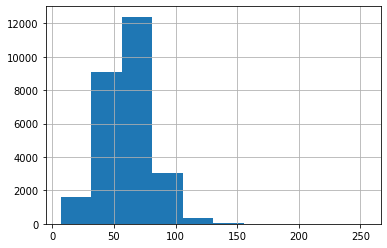

In [15]:
df['headline'].apply(lambda x: len(x)).hist();

The classes are approximately balanced

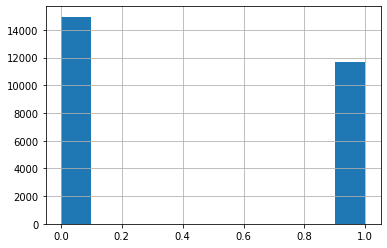

In [16]:
df['is_sarcastic'].hist();

# Preprocessing

The internet is full of emoticons. Maybe it would be a good idea to leave them? Sarcastic headlines may contain more of them than non-sarcastic headlines.

In [17]:
RE_EMOTICONS = re.compile("(:-?\))|(:p)|(:d+)|(:-?\()|(:/)|(;-?\))|(<3)|(=\))|(\)-?:)|(:'\()|(8\))")

for i in range(len(df)):
    match = RE_EMOTICONS.search(df.loc[i, 'headline'])
    if match is not None:
        print(f'Emoticon found: {match[0]}, is its headline sarcastic? {df.loc[i, "is_sarcastic"]}')

Emoticon found: ):, is its headline sarcastic? 0
Emoticon found: ):, is its headline sarcastic? 0


It turns out there is very few of them, so I will get read of them, not to make my data noisy.

I will also take a look at most popular tokens that appear in the headlines

In [18]:
tokens = []
for i in range(len(df)):
    tokens += word_tokenize(df.loc[i, 'headline'])

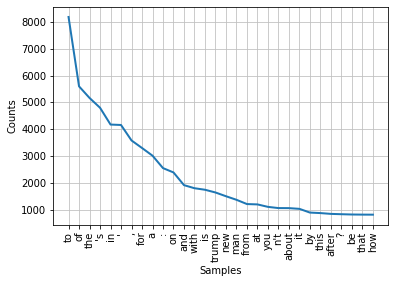

In [19]:
freq_dist = FreqDist(tokens)
freq_dist.plot(30)
plt.show()

It is not a suprise that some stop words appear in the chart, but there are also some other words, like "Trump" or "man". I will compare the results with the one I obtain after some preprocessing. 

In particular, I will:
- remove punctuation, stopwords and unnecessary spaces
- lowercase the words
- tokenize them
- lemmatize them based on the context in which they appear. It is achieved by tagging part of speech using WordNet, a language database that describes the language structure

In [20]:
class Preprocessor(BaseEstimator, TransformerMixin):
    """Scikit-learn compatible tranformer, implementing text preprocessing using nltk.
        Each word in the headline is tokenized and lemmatized based on its context.
        Stop words are removed. Digits can also be removed.
        
        Arguments
        ---------
            remove_digits : bool (default=False), whenever to remove digits from text
            join_tokens : bool (default=True), whenever to join all the tokens to single string
    
    """
    
    def __init__(self, remove_digits=False, join_tokens=True, remove_stop_words=True, fix_stop_words=False):
            self.remove_digits=remove_digits
            self.join_tokens = join_tokens
            self.remove_stop_words = remove_stop_words
            self.fix_stop_words = fix_stop_words
            self.stop_words = set(sw.words('english'))
            self.lemmatizer = WordNetLemmatizer()
        
    def fit(self, X, y=None):
        if self.fix_stop_words:
            self.fix_stopwords()
        return self
    
    def fix_stopwords(self):
        proper_words = ['few', 'itself', 'only', 'until',  'being', 'below', 'each', 'which', 'himself',
                        'into', 'he', 'any', 'by', 'other', 'through', 'before', 'same', 'once', 'now',
                        'their', 'what','her', 'be', 'this', 'but', 'you', 'ourselves', 'how', 'should',
                        'because', 'me', 'yourself', 'our', 'the', 'your', 'we', 'why', 'here', 'my', 'these']
        
        for word in proper_words:
            self.stop_words.remove(word)
    
    def transform(self, X):
        return [self.tokenize(headline) for headline in X]
    
    def tokenize(self, headline):
        tokens = []
        for token, tag in pos_tag(word_tokenize(headline)):
                            
            token = self.lemmatize(token, tag)
            token = self.normalize(token)
            
            if self.remove_stop_words:
                if token in self.stop_words:
                    continue
                    
            if len(token) <= 1:
                continue
                
            tokens.append(token)
            
        if self.join_tokens:
            return ' '.join(tokens)
        else: 
            return tokens
        
    def normalize(self, text):
        if self.remove_digits:
            text = re.sub(r'\d+', '', text)
        text = self.remove_punctuation(text)
        text = text.strip().lower()
        return text
    
    def remove_punctuation(self, text):
        text = ''.join([c for c in text if c not in string.punctuation ])
        return text
                                  
    def lemmatize(self, token, tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)
        

In [21]:
tokens_preprocessed = []
preprocessor = Preprocessor(join_tokens=False)
for i in range(len(df)):
    preprocessed_token = preprocessor.tokenize(df.loc[i, 'headline'])
    tokens_preprocessed += preprocessed_token

After applying preprocessing steps I get much more meaningful results. This time "Trump" tops the list of most frequent words. Politics seems really popular topic of the headlines, what is not a suprise. One can find "Obama", "american", "nation" at the list too.

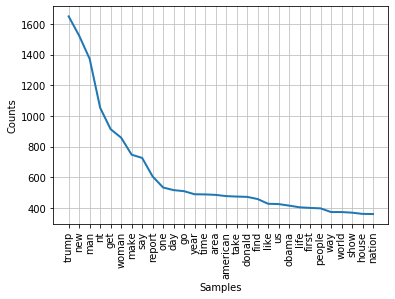

In [22]:
freq_dist_preprocessed = FreqDist(tokens_preprocessed)
freq_dist_preprocessed.plot(30)
plt.show()

What also helps us to understand the text data we are working with are wordclouds

In [23]:
def plot_wordcloud(wordcloud):
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

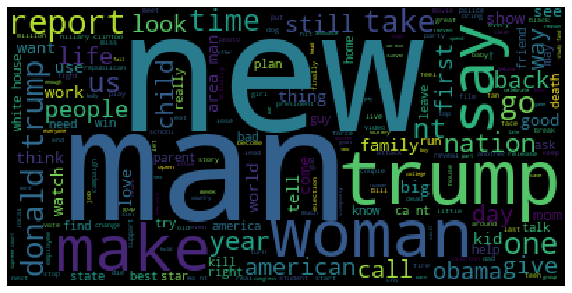

In [24]:
wordcloud = WordCloud().generate(' '.join(tokens_preprocessed))
plot_wordcloud(wordcloud)

Let's take a look at a few of the headlines itself

In [25]:
preprocessed = Preprocessor().fit_transform(df['headline'], df['is_sarcastic'])
preprocessed[:5]

['former versace store clerk sue secret black code minority shopper',
 'roseanne revival catch thorny political mood good bad',
 'mom start fear son web series close thing grandchild',
 'boehner want wife listen come alternative debtreduction idea',
 'jk rowling wish snape happy birthday magical way']

# Classification

For my classification model, I will try logistic regression first. It is know to perform well on simple NLP tasks. With little parameter tuning we can get a decent result. Additionaly, I will experiment with word representation: I will use TF-IDF first, and simple counts second.

Logistic regression accuracy: 0.78


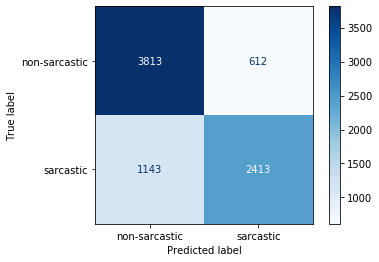

In [26]:
df_train_test = df.copy()
y, X = df['is_sarcastic'], df['headline']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = Pipeline(steps=[
    ('preprocessor', Preprocessor()),
    ('tf_idf', TfidfVectorizer()),
    ('model', LogisticRegression(random_state=42))
])

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Logistic regression accuracy: {round(accuracy_score(y_test, y_pred), 3)}')

plot_confusion_matrix(model, X_test, y_test, display_labels=['non-sarcastic', 'sarcastic'],
                      cmap=plt.cm.Blues, values_format='d')
plt.show()

Logistic regression accuracy: 0.785


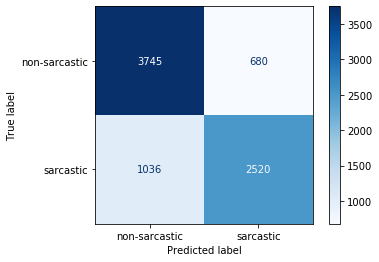

In [27]:
model = Pipeline(steps=[
    ('preprocessor', Preprocessor()),
    ('count_vec', CountVectorizer()),
    ('model', LogisticRegression(random_state=42))
])

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Logistic regression accuracy: {round(accuracy_score(y_test, y_pred), 3)}')

plot_confusion_matrix(model, X_test, y_test, display_labels=['non-sarcastic', 'sarcastic'],
                      cmap=plt.cm.Blues, values_format='d')
plt.show()

Two ways of representating words perform comparatively.

I've also tried how the model works with larger vocabulary, without removing stop words. It turns out they are not always only noise, our model performs better now! 

In particular, there is less false negatives: prieviously it made the mistake of marking sarcastic headlines are non-sarcastic more often.

Logistic regression without removig stop words accuracy: 0.831


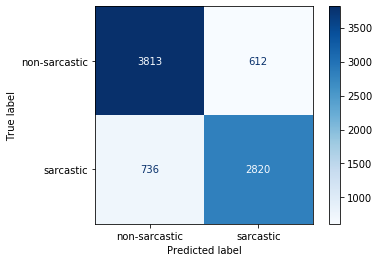

In [28]:
model = Pipeline(steps=[
    ('preprocessor', Preprocessor(remove_stop_words=False)),
    ('tf_idf', TfidfVectorizer()),
    ('model', LogisticRegression(random_state=42))
])

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'Logistic regression without removig stop words accuracy: {round(accuracy_score(y_test, y_pred), 3)}')

plot_confusion_matrix(model, X_test, y_test, display_labels=['non-sarcastic', 'sarcastic'],
                      cmap=plt.cm.Blues, values_format='d')
plt.show()

It may mean that one shouldn't blindly perform stopwords removal. Let's check which words are consider stopwords according to nltk. Maybe we should pop some of them from this list?

In [29]:
def verify_preprocessing(headlines, labels):
    lemmatizer = WordNetLemmatizer()
    discarded_tokens = dict()
    discarded_tokens_class_prob = dict()
    
    for i in range(len(headlines)):
        for token, tag in pos_tag(word_tokenize(headlines[i])):
            tag = {
                    'N': wn.NOUN,
                    'V': wn.VERB,
                    'R': wn.ADV,
                    'J': wn.ADJ
                }.get(tag[0], wn.NOUN)

            token = lemmatizer.lemmatize(token, tag)
            
            if len(token) <= 1:
                continue

            if token in set(sw.words('english')):
                if token in discarded_tokens:
                    discarded_tokens[token] += 1
                    discarded_tokens_class_prob[token] += labels[i]
                else:
                    discarded_tokens[token] = 1
                    discarded_tokens_class_prob[token] = labels[i]
                    
    discarded_tokens_class_prob = {k: v / discarded_tokens[k] for k, v in discarded_tokens_class_prob.items()}
    
    return discarded_tokens, discarded_tokens_class_prob
    
    
discarded_tokens, discarded_tokens_class_prob = verify_preprocessing(X_train.values, y_train.values)

In [30]:
discarded_tokens

{'the': 3590,
 'be': 2834,
 'into': 352,
 'this': 599,
 'up': 519,
 'out': 555,
 'of': 3924,
 'after': 575,
 'to': 5735,
 'on': 1679,
 'when': 218,
 'that': 558,
 'he': 538,
 'what': 479,
 'it': 819,
 'have': 926,
 'why': 352,
 'so': 144,
 'for': 2342,
 'me': 83,
 'from': 863,
 'other': 119,
 'an': 254,
 'against': 142,
 'in': 2946,
 'all': 360,
 'there': 121,
 'how': 559,
 'once': 61,
 'over': 324,
 'where': 109,
 'down': 203,
 'with': 1273,
 'you': 774,
 'at': 819,
 'by': 605,
 'we': 234,
 'during': 150,
 'off': 245,
 'before': 192,
 'can': 310,
 'himself': 38,
 'some': 129,
 'they': 246,
 'their': 204,
 'own': 117,
 'who': 431,
 'his': 434,
 'only': 152,
 'not': 486,
 'and': 1329,
 'but': 149,
 'do': 722,
 'below': 4,
 'if': 210,
 'she': 205,
 'now': 265,
 'our': 120,
 'should': 205,
 'about': 756,
 'her': 291,
 'more': 375,
 'same': 56,
 'while': 117,
 'your': 441,
 'will': 387,
 'as': 57,
 'any': 76,
 'again': 109,
 'no': 252,
 'above': 10,
 'here': 168,
 'or': 152,
 'than': 223,


We can see that some of the tokens are quite meaningful and for a great number of them the probabilty of the their headline being sarcastic is higher (or lower than the mean).

In [31]:
print(f'Class proportion in training dataset: {round(y_train.sum() / len(y_train), 3)}')

Class proportion in training dataset: 0.435


In [32]:
sorted(discarded_tokens_class_prob.items(), key=lambda item: item[1], reverse=True)

[('below', 1.0),
 ('ll', 1.0),
 ('whom', 1.0),
 ('ma', 1.0),
 ('itself', 0.8421052631578947),
 ('each', 0.8070175438596491),
 ('until', 0.8),
 ('few', 0.7962962962962963),
 ('only', 0.7763157894736842),
 ('being', 0.75),
 ('any', 0.7368421052631579),
 ('which', 0.7272727272727273),
 ('himself', 0.6842105263157895),
 ('into', 0.6761363636363636),
 ('through', 0.6610169491525424),
 ('by', 0.6495867768595042),
 ('he', 0.6468401486988847),
 ('same', 0.6428571428571429),
 ('both', 0.6428571428571429),
 ('before', 0.6354166666666666),
 ('him', 0.6176470588235294),
 ('such', 0.6153846153846154),
 ('between', 0.6029411764705882),
 ('above', 0.6),
 ('herself', 0.6),
 ('out', 0.5945945945945946),
 ('now', 0.5924528301886792),
 ('other', 0.5882352941176471),
 ('some', 0.5813953488372093),
 ('during', 0.58),
 ('they', 0.5772357723577236),
 ('off', 0.5755102040816327),
 ('once', 0.5737704918032787),
 ('own', 0.5726495726495726),
 ('just', 0.5721518987341773),
 ('those', 0.5714285714285714),
 ('wher

We should be very careful about the way we handle that. Probably it would be a good idea to ask language experts  what should we do in this particular application. Data preprocessing can have a great impact on usefulness of our models. Data scientists should always think about veryfication of results they get. In case of logistic regression that I've used here, the order in which words appear in the headlines doesn't metter, but in case of sequence models it can have significant importance - consider tokens like 'not'.

I've tried removing some tokens from the list of stopwords, and noticed that the accuracy increases.

Logistic regression accuracy: 0.823


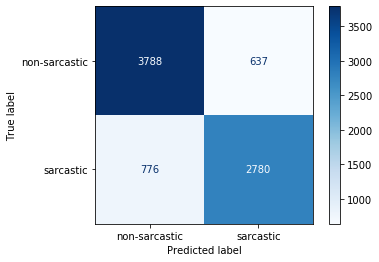

In [33]:
model = Pipeline(steps=[
    ('preprocessor', Preprocessor(fix_stop_words=True)),
    ('tf_idf', TfidfVectorizer()),
    ('model', LogisticRegression(random_state=42))
])

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Logistic regression accuracy: {round(accuracy_score(y_test, y_pred), 3)}')

plot_confusion_matrix(model, X_test, y_test, display_labels=['non-sarcastic', 'sarcastic'],
                      cmap=plt.cm.Blues, values_format='d')
plt.show()

We can try to improve classification result by parameter tuning. I will try different values for regularization term.

In [34]:
logistic = LogisticRegression(random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', Preprocessor(remove_stop_words=False)),
    ('tf_idf', TfidfVectorizer()),
    ('logistic', logistic)
])

params = {
    'logistic__C': [0.1, 0.5, 1.0, 2.0]
}

search = GridSearchCV(pipeline, param_grid=params)
search = search.fit(X_train, y_train)
print(f'Best CV score: {search.best_score_}')

y_pred = search.predict(X_test)
print(f'Fine-tuned logistic regression accuracy: {round(accuracy_score(y_test, y_pred), 3)}')

Best CV score: 0.8316417938422278
Fine-tuned logistic regression accuracy: 0.835


We achieved slightly better result using less regularization. The results in the table clearly indicates that the less regularization, the betted the model performed.

In [35]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,16.951531,1.458514,4.313102,0.622951,0.1,{'logistic__C': 0.1},0.785772,0.801020,0.785177,0.789742,0.796992,0.791741,0.006267,4
1,16.427202,0.589367,4.124985,0.352338,0.5,{'logistic__C': 0.5},0.814765,0.835124,0.815521,0.819280,0.832707,0.823479,0.008691,3
2,15.998402,0.776272,4.053964,0.403585,1,{'logistic__C': 1.0},0.824966,0.837272,0.820623,0.826531,0.838883,0.829655,0.007162,2
3,15.742619,0.671587,3.955106,0.323520,2,{'logistic__C': 2.0},0.829799,0.840226,0.821697,0.827336,0.839151,0.831642,0.007084,1


We can check which words got the biggest coefficients

In [36]:
pd.DataFrame(search.best_estimator_['logistic'].coef_[0], 
             columns=['coefficient'],
             index=search.best_estimator_['tf_idf'].get_feature_names()).sort_values(by='coefficient', ascending=False).T

,nation,area,man,report,only,local,fuck,of,self,study,...,my,how,donald,why,an,your,be,trump,and,the
coefficient,7.902981,7.175414,6.047503,5.171979,4.502354,4.487352,4.06124,4.051307,3.696479,3.599335,...,-4.369171,-4.544651,-4.750526,-5.018696,-5.097787,-5.464287,-5.526735,-6.595798,-7.745464,-11.562228


I've also tried removing digits in the headlines, but it doesn't have much effect on classification.

In [37]:
model = Pipeline(steps=[
    ('preprocessor', Preprocessor(remove_stop_words=False, remove_digits=True)),
    ('tf_idf', TfidfVectorizer()),
    ('model', LogisticRegression(C=2, random_state=42))
])

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Logistic regression accuracy with no stop words and no digits: {round(accuracy_score(y_test, y_pred), 3)}')

Logistic regression accuracy with no stop words and no digits: 0.834


I've also tried to use Naive Bayes classifier and it performs almost equally well as logistic regression.

In [38]:
nb_pipeline = Pipeline(steps=[
    ('preprocessor', Preprocessor(remove_stop_words=False)),
    ('count_vec', CountVectorizer()),
    ('nb', MultinomialNB())
])

naive_bayes = nb_pipeline

naive_bayes = naive_bayes.fit(X_train, y_train)
nb_pred = naive_bayes.predict(X_test)
print(f'Naive Bayes accuracy: {round(accuracy_score(y_test, nb_pred), 3)}')

Naive Bayes accuracy: 0.836


XGBoost, Kaggle comptetitons-winning model, does not perform that well on this data. It gives worse results than some simpler models.

In [39]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', Preprocessor(remove_stop_words=False)),
    ('count_vec', CountVectorizer()),
    ('xgb', xgb.XGBClassifier(random_state=42))
])

params = {
    'xgb__max_depth': [5, 7]
}

xgb_search = GridSearchCV(xgb_pipeline, param_grid=params)

xgb_classifier = xgb_search.fit(X_train, y_train)
xgb_pred = xgb_classifier.predict(X_test)
print(f'XGBoost accuracy: {round(accuracy_score(y_test, xgb_pred), 3)}')

XGBoost accuracy: 0.776


After trying several preprocessing strategies and some classical machine learning models I was curious how deep neural networks will perform on this data. I will present second notebook describing deep learning - based approach. In order to be sure that my train-test split is the same I've used above, I've saved training and testing data to separate files. Additionaly, I created a validation set from fraction of training data.

In [40]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv('data/train.csv', index=False)
val_df.to_csv('data/val.csv', index=False)
test_df.to_csv('data/test.csv', index=False)